<a href="https://colab.research.google.com/github/bbanzai88/Data-Science-Repository/blob/main/Kmeans_with_SHAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this colab notebook, we use kmeans and we  build a classification model on top of it to determine the quality of the clustering and to aid explaining the driving features for each cluster.. If the clusters are of high quality, the classification model will be able to predict them with high accuracy.  

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline 
from sklearn.cluster import KMeans
from sklearn import datasets
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
wine=pd.read_csv('/content/sample_data/wine-clustering.csv')
wine_df=pd.DataFrame(wine)
wine_df.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


scale data

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Because K-Means only works with numerical data, I’ll:

One-Hot-Encode the categorical data
Apply the Yeo-Johnson transformation to the data to make it more Gaussian like
Fit K-Means with 3 clusters

In [ ]:
from sklearn.cluster import KMeans


from numpy import exp
from numpy.random import randn
from sklearn.preprocessing import PowerTransformer
from tqdm import tqdm
import plotly.graph_objects as go

#One-Hot-Encoding
data = pd.get_dummies(wine_df)

#Pre-processing
for c in data.columns:
    pt = PowerTransformer()
    data.loc[:, c] = pt.fit_transform(np.array(data[c]).reshape(-1, 1))

#Actual Clustering
kmeans = KMeans(n_clusters=3).fit(data)
kmeans_labels = kmeans.labels_


#Use Elbow method to choose the optimal number of clusters
sse = {}
for k in tqdm(range(2, 50)):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    
fig = go.Figure(data=go.Scatter(x=list(sse.keys()), y=list(sse.values())))
fig.show()

100%|██████████| 48/48 [00:14<00:00,  3.29it/s]


Evaluation by Classification

I’m going to treat the clusters as labels and build a classification model on top. If the clusters are of high quality, the classification model will be able to predict them with high accuracy. At the same time, the models should use a variety of features to ensure that the clusters are not too simplistic. Overall, I’ll check the following attributes:

Distinctiveness of clusters by cross-validated F1 score
Informativeness of clusters by SHAP feature importances

I will use LightGBM as my classifier because it can use categorical features and you can easily get the SHAP values for the trained models.

In [ ]:
import lightgbm as ltb
from sklearn.model_selection import cross_val_score

#Setting the objects to category 
lgbm_data = wine_df.copy()
for c in lgbm_data.select_dtypes(include='object'):
    lgbm_data[c] = lgbm_data[c].astype('category')

#KMeans clusters
clf_km = ltb.LGBMClassifier(colsample_by_tree=0.8)
cv_scores_km = cross_val_score(clf_km, lgbm_data, kmeans_labels, scoring='f1_weighted')
print(f'CV F1 score for K-Means clusters is {np.mean(cv_scores_km)}')

CV F1 score for K-Means clusters is 0.9596643901302286


A CV score for K-means is 0.986 which means that the wine data is grouped into meaningful and distinguishable clusters. Now, let’s see the feature importances to determine if the classifier has used all the information available to it.

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


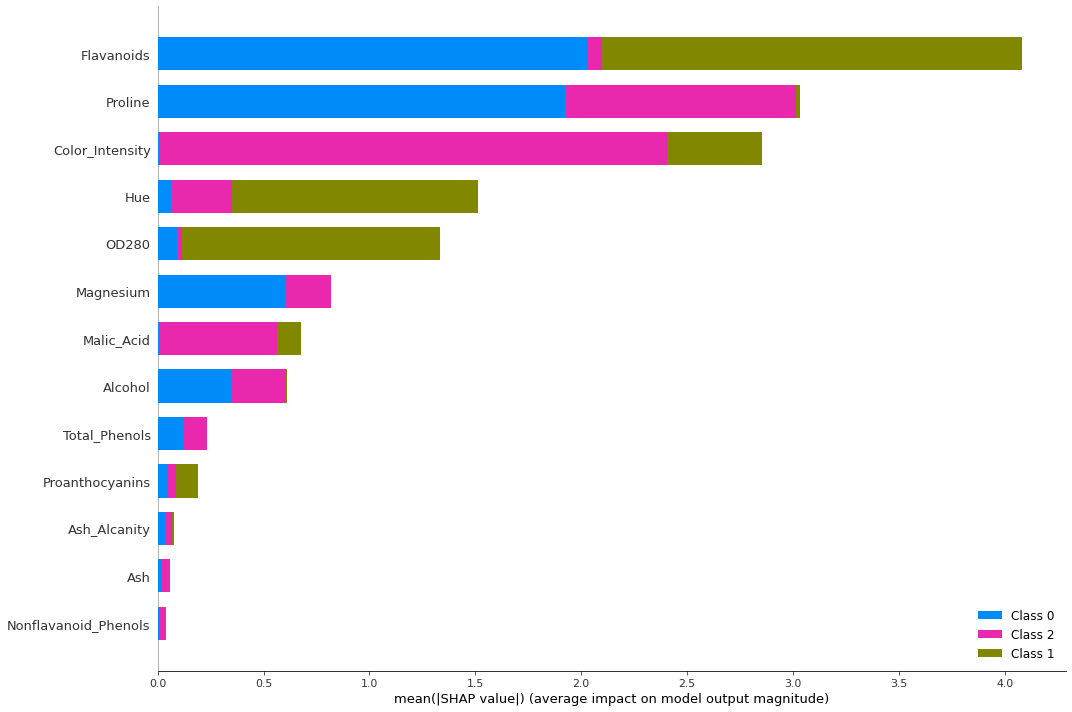

In [ ]:
import shap

#Fit the model
clf_km.fit(lgbm_data, kmeans_labels)

#SHAP values
explainer_km = shap.TreeExplainer(clf_km)
shap_values_km = explainer_km.shap_values(lgbm_data)
shap.summary_plot(shap_values_km, lgbm_data, plot_type="bar", plot_size=(15, 10))

It seems like the classifier has mainly used 8 features and all the others have marginal importance. 
